# Observables for the photometric survey and probe combination

Here, we are considering $6$ cosmological models, that have diferent amount of cosmological parameters to be calculated (its errors):

1. $\Lambda CDM$ flat ($5$)
2. $\Lambda CDM$ non-flat ($6$)
3. $w_0$, $w_a$ flat ($7$)
4. $w_0$, $w_a$ non-flat ($8$)
5. $w_0$, $w_a$, $\gamma$ flat ($8$)
6. $w_0$, $w_a$, $\gamma$ non-flat ($9$)

In [108]:
import numpy as np
import sympy as smp
import matplotlib.pyplot as plt
import pandas as pd
import camb
from camb import model

# For interpolation
from scipy.interpolate import RectBivariateSpline, interp2d

import warnings

# Ignore DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message=".*divmax.*")

import logging
# Basic registry settings
logging.basicConfig(level=logging.INFO)

## Fiducial values

In [109]:
Omega_c0 = 0.2685628338348412

Omega_nu0 = 0.00143717

Omega_b0 = 0.05

Omega_m0 = 0.32 # Omega_c0 + Omega_nu0 + Omega_b0

Omega_DE0 = 0.68 #Omega_lambda = (1-Omega_m0)

w0= -1

wa = 0

Omega_K0 = 0

h = 0.67

c = 299792

sigma8 = 0.816

ns = 0.96

gamma = 6/11

Aia = 1.72

Cia = 0.0134

### For comparison

(The comparison have to be less than 10). 

In [110]:
def comparison(created, expected):
    return 100*np.abs(1 - (created/expected))

In [111]:
class ClassIntegration:
    def __init__(self, params):
        self.z = params['z']
        self.model = params['model']

    def E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        if self.model == 'ACDM_flat':
            Omega_k0 = 0 
            Omega_DE0 = 1 - (Omega_m0)
            w0, wa = -1, 0
        elif self.model == 'ACDM_non_flat':
            Omega_k0 = 1 - (Omega_m0 + Omega_DE0)
            w0, wa = -1, 0
        elif self.model == 'non_ACDM_flat':
            Omega_k0 = 0 
            Omega_DE0 = 1 - (Omega_m0)
        elif self.model == 'non_ACDM_non_flat':
            Omega_k0 = 1 - (Omega_m0 + Omega_DE0)
        elif self.model == 'non_ACDM_flat_gamma':
            Omega_k0 = 0
            Omega_DE0 = 1 - (Omega_m0)
        elif self.model == 'non_ACDM_non_flat_gamma':
            Omega_k0 = 0
        radicando = Omega_m0 * (1 + z)**3 + (Omega_DE0 * (1 + z)**(3 * (1 + wa + w0)) * np.exp(-3 * wa * (z / (1 + z)))) + (Omega_k0) * (1 + z)**2
        return np.sqrt(radicando)
    
    def D(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        z_prime = np.linspace(0, z, 30)
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Omega_m = (Omega_m0  * (1 + z_prime)**3) / (E_array**2)
        delta = z / len(z_prime)
        integral = np.sum((Omega_m**gamma / (1 + z_prime)) * delta)
        return np.exp(-integral)

    def inverse_E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        return 1 / self.E2(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

    def n_t(self, z):
        z_m, z_0 = 0.9, 0.9 / np.sqrt(2)
        return ((z / z_0)**2) * np.exp(-(z / z_0)**(3 / 2))

    def p_ph(self, z_p, z):
        def gauss(c, z0, s, z, zp):
            return (1 / (np.sqrt(2 * np.pi) * s * (1 + z))) * np.exp(-0.5 * ((z - (c * zp) - z0) / (s * (1 + z)))**2)
        return (1 - 0.1) * gauss(1, 0, 0.05, z, z_p) + 0.1 * gauss(1, 0.1, 0.05, z, z_p)

    def r(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        c = 299792
        H_0 = (100 * h)
        z_prime = np.linspace(0, z, 30)
        delta = z / len(z_prime)
        integrand = self.inverse_E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) * delta
        return np.sum(integrand) * (c / H_0) 

    def n_i_try(self, i, z):
        z_bins = [0.001, 0.42, 0.56, 0.68, 0.79, 0.9, 1.02, 1.15, 1.32, 1.58, 2.5]
        denominators = np.array([0.04599087, 0.04048852, 0.04096115, 0.03951212, 0.03886145, 0.03944441, 0.03751183, 0.03950185, 0.04042198, 0.03827518])

        def numerator_n_i(i, z):
            z_prime = np.linspace(z_bins[i], z_bins[i + 1], 20)
            delta = (z_bins[i + 1] - z_bins[i]) / len(z_prime)
            multiplication_array = self.n_t(z) * self.p_ph(z_prime, z)
            return np.sum(multiplication_array * delta)

        return numerator_n_i(i, z) / denominators[i]

    def Window_gamma(self, i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        H_0 = (100 * h)
        c = 299792
        result = []
        for z in self.z:
            z_max = 2.5
            z_prime = np.linspace(z, z_max, 20)
            delta = (z_max - z) / len(z_prime)
            r_true = self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) / (c / H_0)
            n_array = np.array([self.n_i_try(i, zs) for zs in z_prime])
            r_array = np.array([(self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) / (c / H_0)) for zs in z_prime])
            integrand = n_array * (1 - (r_true  / r_array)) * delta
            result.append(np.sum(integrand))
        return np.array(result)
    
    def Window_L(self, i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, b):
        H_0 = (100 * h)
        c = 299792
        result = []
        W_gamma = self.Window_gamma(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        for z in self.z:
            z_max = 2.5
            z_prime = np.linspace(z, z_max, 20)
            delta = (z_max - z) / len(z_prime)
            n_array = np.array([self.n_i_try(i, zs) for zs in z_prime])
            E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
            D_array = np.array([self.D(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

            integrand = ((Aia * Cia * Omega_m0 * (n_array * E_array)) / D_array) * delta
            result.append(np.sum(integrand))
        second = (H_0 / c) * np.array(result)
        return (W_gamma - second)
    
    def Window_G(self, i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, b):
        #z_bins = [0.001, 0.42, 0.56, 0.68, 0.79, 0.9, 1.02, 1.15, 1.32, 1.58, 2.5]
        #z_mean = z_bins[i] + ((z_bins[i+1] - z_bins[i]) / 2)
        #b_i = np.sqrt(1 + z_mean)
        H_0 = (100 * h)
        c = 299792
        result = []
        for z in self.z:
            z_max = 2.5
            z_prime = np.linspace(z, z_max, 20)
            delta = (z_max - z) / len(z_prime)
            n_array = np.array([self.n_i_try(i, zs) for zs in z_prime])
            H_array = H_0 * self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
            integrand = (b * n_array * H_array / c) * delta
            result.append(np.sum(integrand))
        return np.array(result)

In [112]:
z = np.linspace(0.001, 2.5, 20)

params = {'z': z, 'model': 'ACDM_flat'}

A = ClassIntegration(params)

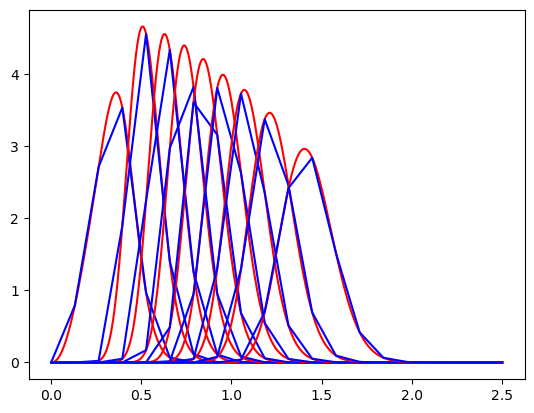

In [113]:
for i in range(0, 9):
    z_perfect = np.linspace(0.001, 2.5, 1000)
    n = np.array([A.n_i_try(i, zs) for zs in z_perfect])
    plt.plot(z_perfect, n, 'red')
    n = np.array([A.n_i_try(i, zs) for zs in z])
    plt.plot(z, n, 'blue')

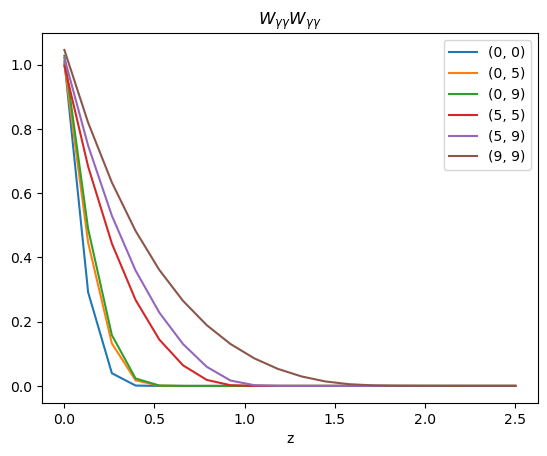

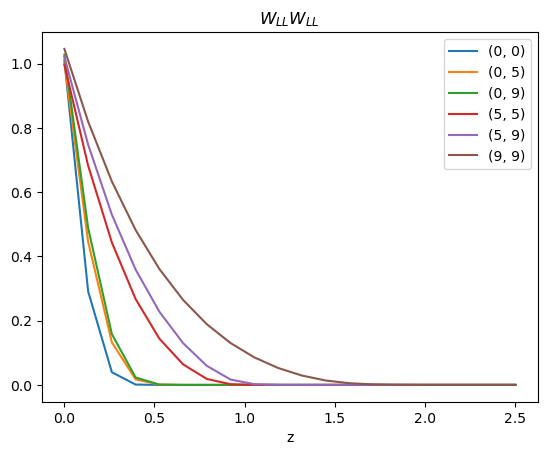

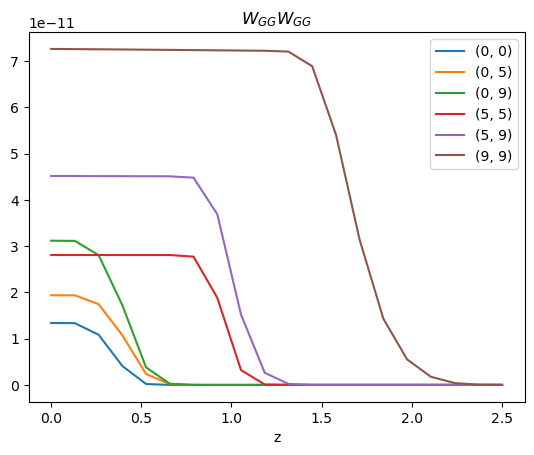

In [114]:
pairs = [(0, 0), (0, 5), (0, 9), (5, 5), (5, 9), (9, 9)]

for (i, j) in pairs:
    B = A.Window_gamma(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
    C = A.Window_gamma(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
    plt.plot(z, B * C,  label = str((i, j)))
    plt.title('$W_{\gamma \gamma}W_{\gamma \gamma}$')
    plt.xlabel('z')
plt.legend()
plt.show()

for (i, j) in pairs:
    B = A.Window_L(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, Cia)
    C = A.Window_L(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, Cia)
    plt.plot(z, B * C,  label = str((i, j)))
    plt.title('$W_{L L}W_{L L}$')
    plt.xlabel('z')
plt.legend()
plt.show()

for (i, j) in pairs:
    B = A.Window_G(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, Cia)
    C = A.Window_G(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, Cia)
    plt.plot(z, B * C,  label = str((i, j)))
    plt.title('$W_{G G}W_{G G}$')
    plt.xlabel('z')
plt.legend()
plt.show()

## Usando CAMB

## $P_{\delta \delta}$

In [115]:
pars = camb.CAMBparams()

# Establece la cosmología
pars.set_cosmology(H0=100*h, ombh2=Omega_b0*h**2, omch2=(Omega_m0 - Omega_b0)*h**2)

# Establece los parámetros de energía oscura
pars.set_dark_energy(w=w0, wa=wa)

# Establece los parámetros del espectro de potencia
pars.InitPower.set_params(ns=ns)  # As es la amplitud del espectro

redshifts = np.logspace(np.log10(0.001), np.log10(2.5), 50)

# set non-linear Matter Power Spectrum
pars.NonLinear = model.NonLinear_pk
pars.set_matter_power(redshifts=redshifts, kmax=50)
results = camb.get_results(pars)
kh_nl, z_nl, PK_nl = results.get_matter_power_spectrum(minkh=2e-05, maxkh=55)

Note: redshifts have been re-sorted (earliest first)


In [116]:
print(min(kh_nl), max(kh_nl))

2e-05 55.00000000000007


INFO:matplotlib.mathtext:Substituting symbol P from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol P from STIXNonUnicode


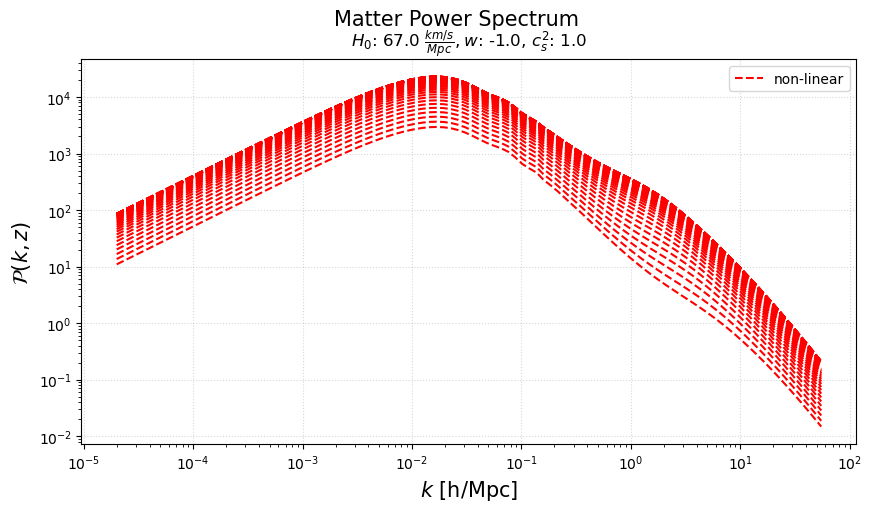

In [117]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharey=True)

for iz, redshift in enumerate(redshifts):
    ax.loglog(kh_nl, PK_nl[iz, :], color='r', ls='--')


ax.legend(['non-linear'], loc='upper right')
ax.set_ylabel(r"$\mathcal{P}(k, z)$", fontsize=15)
ax.set_xlabel(r"$k$ [h/Mpc]", fontsize=15)
ax.set_title(f"$H_0$: {pars.H0} $\\frac{{km/s}}{{Mpc}}, $" + 
                f"$w$: {pars.DarkEnergy.w}, $c_s^2$: {pars.DarkEnergy.cs2}")
ax.grid(alpha=0.5, ls=':')
fig.suptitle("Matter Power Spectrum", fontsize=15)

plt.show()

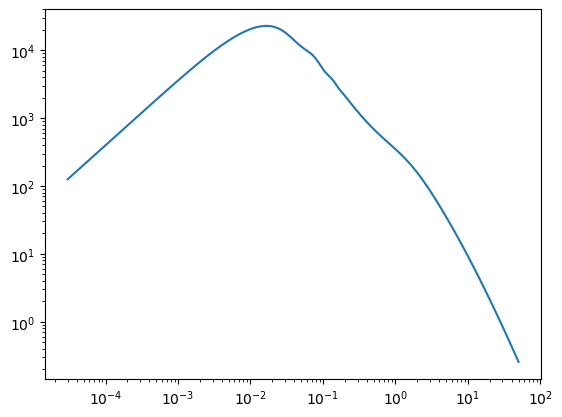

In [118]:
interp_func = RectBivariateSpline(z_nl, kh_nl, np.log10(PK_nl))

k_array = np.logspace(np.log10(3e-5), np.log10(50), 700)
z_array = np.linspace(0.001, 2.5, 100)

plt.plot(k_array, 10**interp_func(0.01, k_array)[0,:])
plt.xscale('log')
plt.yscale('log')
plt.show()

## 1. $\partial P_{\delta \delta} / \partial \Omega_{m,0}$

In [119]:
pars = camb.CAMBparams()
epsilon = 0.01

# Adelante

pars.set_cosmology(H0=100*h, ombh2=Omega_b0*h**2, omch2=(Omega_m0 * (1 + epsilon)  - Omega_b0)*h**2)
pars.set_dark_energy(w=w0, wa=wa)
pars.InitPower.set_params(ns=ns)  # As es la amplitud del espectro
redshifts = np.logspace(np.log10(0.001), np.log10(2.5), 50)
pars.NonLinear = model.NonLinear_pk
pars.set_matter_power(redshifts=redshifts, kmax=50)
results = camb.get_results(pars)
kh_nl, z_nl, PK_pl_om = results.get_matter_power_spectrum(minkh=2e-05, maxkh=55)

# Atras
pars.set_cosmology(H0=100*h, ombh2=Omega_b0*h**2, omch2=(Omega_m0 * (1 - epsilon) - Omega_b0)*h**2)
pars.set_dark_energy(w=w0, wa=wa)
pars.InitPower.set_params(ns=ns)  # As es la amplitud del espectro
redshifts = np.logspace(np.log10(0.001), np.log10(2.5), 50)
pars.NonLinear = model.NonLinear_pk
pars.set_matter_power(redshifts=redshifts, kmax=50)
results = camb.get_results(pars)
kh_nl, z_nl, PK_mn_om = results.get_matter_power_spectrum(minkh=2e-05, maxkh=55)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


In [120]:
der_PK_pl_om = (PK_pl_om - PK_mn_om) / (2 * epsilon * Omega_m0)
der_PK_pl_om_int = RectBivariateSpline(z_nl, kh_nl, np.log10(der_PK_pl_om))

C:\Users\MICROSOSFT\AppData\Local\Temp\ipykernel_8240\1287316116.py:2: RuntimeWarning: invalid value encountered in log10
  der_PK_pl_om_int = RectBivariateSpline(z_nl, kh_nl, np.log10(der_PK_pl_om))


## 2. $\partial P_{\delta \delta} / \partial \Omega_{b,0}$

In [121]:
pars = camb.CAMBparams()
epsilon = 0.01

# Adelante

pars.set_cosmology(H0=100*h, ombh2=Omega_b0*h**2, omch2=(Omega_m0  - Omega_b0 * (1 + epsilon))*h**2)
pars.set_dark_energy(w=w0, wa=wa)
pars.InitPower.set_params(ns=ns)  # As es la amplitud del espectro
redshifts = np.logspace(np.log10(0.001), np.log10(2.5), 50)
pars.NonLinear = model.NonLinear_pk
pars.set_matter_power(redshifts=redshifts, kmax=50)
results = camb.get_results(pars)
kh_nl, z_nl, PK_pl_ob = results.get_matter_power_spectrum(minkh=2e-05, maxkh=55)

# Atras
pars.set_cosmology(H0=100*h, ombh2=Omega_b0*h**2, omch2=(Omega_m0 - Omega_b0 * (1 - epsilon))*h**2)
pars.set_dark_energy(w=w0, wa=wa)
pars.InitPower.set_params(ns=ns)  # As es la amplitud del espectro
redshifts = np.logspace(np.log10(0.001), np.log10(2.5), 50)
pars.NonLinear = model.NonLinear_pk
pars.set_matter_power(redshifts=redshifts, kmax=50)
results = camb.get_results(pars)
kh_nl, z_nl, PK_mn_ob = results.get_matter_power_spectrum(minkh=2e-05, maxkh=55)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


In [122]:
der_PK_pl_ob = (PK_pl_ob - PK_mn_ob) / (2 * epsilon * Omega_b0)
der_PK_pl_ob_int = RectBivariateSpline(z_nl, kh_nl, np.log10(der_PK_pl_ob))

C:\Users\MICROSOSFT\AppData\Local\Temp\ipykernel_8240\3856841138.py:2: RuntimeWarning: invalid value encountered in log10
  der_PK_pl_ob_int = RectBivariateSpline(z_nl, kh_nl, np.log10(der_PK_pl_ob))


## 3. $\partial P_{\delta \delta} / \partial h$

In [123]:
pars = camb.CAMBparams()
epsilon = 0.01

# Adelante

pars.set_cosmology(H0=100*h*(1 + epsilon), ombh2=Omega_b0*(h* (1 + epsilon))**2, omch2=(Omega_m0  - Omega_b0)*(h*(1 + epsilon))**2)
pars.set_dark_energy(w=w0, wa=wa)
pars.InitPower.set_params(ns=ns)  # As es la amplitud del espectro
redshifts = np.logspace(np.log10(0.001), np.log10(2.5), 50)
pars.NonLinear = model.NonLinear_pk
pars.set_matter_power(redshifts=redshifts, kmax=50)
results = camb.get_results(pars)
kh_nl, z_nl, PK_pl_h = results.get_matter_power_spectrum(minkh=2e-05, maxkh=55)

# Atras
pars.set_cosmology(H0=100*h*(1 - epsilon), ombh2=Omega_b0*(h*(1 - epsilon))**2, omch2=(Omega_m0 - Omega_b0)*(h*(1 - epsilon))**2)
pars.set_dark_energy(w=w0, wa=wa)
pars.InitPower.set_params(ns=ns)  # As es la amplitud del espectro
redshifts = np.logspace(np.log10(0.001), np.log10(2.5), 50)
pars.NonLinear = model.NonLinear_pk
pars.set_matter_power(redshifts=redshifts, kmax=50)
results = camb.get_results(pars)
kh_nl, z_nl, PK_mn_h = results.get_matter_power_spectrum(minkh=2e-05, maxkh=55)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


In [124]:
der_PK_pl_h = (PK_pl_h - PK_mn_h) / (2 * epsilon * h)
der_PK_pl_h_int = RectBivariateSpline(z_nl, kh_nl, np.log10(der_PK_pl_h))

C:\Users\MICROSOSFT\AppData\Local\Temp\ipykernel_8240\2335257895.py:2: RuntimeWarning: invalid value encountered in log10
  der_PK_pl_h_int = RectBivariateSpline(z_nl, kh_nl, np.log10(der_PK_pl_h))


## 4. $\partial P_{\delta \delta} / \partial w_0$

In [125]:
pars = camb.CAMBparams()
epsilon = 0.01

# Adelante

pars.set_cosmology(H0=100*h, ombh2=Omega_b0*h**2, omch2=(Omega_m0  - Omega_b0)*h**2)
pars.set_dark_energy(w=w0*(1 + epsilon), wa=wa)
pars.InitPower.set_params(ns=ns)  # As es la amplitud del espectro
redshifts = np.logspace(np.log10(0.001), np.log10(2.5), 50)
pars.NonLinear = model.NonLinear_pk
pars.set_matter_power(redshifts=redshifts, kmax=50)
results = camb.get_results(pars)
kh_nl, z_nl, PK_pl_w0 = results.get_matter_power_spectrum(minkh=2e-05, maxkh=55)

# Atras
pars.set_cosmology(H0=100*h, ombh2=Omega_b0*h**2, omch2=(Omega_m0 - Omega_b0)*h**2)
pars.set_dark_energy(w=w0*(1 - epsilon), wa=wa)
pars.InitPower.set_params(ns=ns)  # As es la amplitud del espectro
redshifts = np.logspace(np.log10(0.001), np.log10(2.5), 50)
pars.NonLinear = model.NonLinear_pk
pars.set_matter_power(redshifts=redshifts, kmax=50)
results = camb.get_results(pars)
kh_nl, z_nl, PK_mn_w0 = results.get_matter_power_spectrum(minkh=2e-05, maxkh=55)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


In [126]:
der_PK_pl_w0 = (PK_pl_w0 - PK_mn_w0) / (2 * epsilon * w0)
der_PK_pl_w0_int = RectBivariateSpline(z_nl, kh_nl, np.log10(der_PK_pl_w0))

C:\Users\MICROSOSFT\AppData\Local\Temp\ipykernel_8240\880771349.py:2: RuntimeWarning: invalid value encountered in log10
  der_PK_pl_w0_int = RectBivariateSpline(z_nl, kh_nl, np.log10(der_PK_pl_w0))


## 5. $\partial P_{\delta \delta} / \partial w_a$

In [127]:
pars = camb.CAMBparams()
epsilon = 0.01

# Adelante

pars.set_cosmology(H0=100*h, ombh2=Omega_b0*h**2, omch2=(Omega_m0  - Omega_b0)*h**2)
pars.set_dark_energy(w=w0, wa=wa + epsilon)
pars.InitPower.set_params(ns=ns)  # As es la amplitud del espectro
redshifts = np.logspace(np.log10(0.001), np.log10(2.5), 50)
pars.NonLinear = model.NonLinear_pk
pars.set_matter_power(redshifts=redshifts, kmax=50)
results = camb.get_results(pars)
kh_nl, z_nl, PK_pl_wa = results.get_matter_power_spectrum(minkh=2e-05, maxkh=55)

# Atras
pars.set_cosmology(H0=100*h, ombh2=Omega_b0*h**2, omch2=(Omega_m0 - Omega_b0)*h**2)
pars.set_dark_energy(w=w0, wa=wa - epsilon)
pars.InitPower.set_params(ns=ns)  # As es la amplitud del espectro
redshifts = np.logspace(np.log10(0.001), np.log10(2.5), 50)
pars.NonLinear = model.NonLinear_pk
pars.set_matter_power(redshifts=redshifts, kmax=50)
results = camb.get_results(pars)
kh_nl, z_nl, PK_mn_wa = results.get_matter_power_spectrum(minkh=2e-05, maxkh=55)

Note: redshifts have been re-sorted (earliest first)


CAMBError: fluid dark energy model does not support w crossing -1

In [106]:
der_PK_pl_wa = (PK_pl_wa - PK_mn_wa) / (2 * epsilon)
der_PK_pl_wa_int = RectBivariateSpline(z_nl, kh_nl, np.log10(der_PK_pl_wa))

C:\Users\MICROSOSFT\AppData\Local\Temp\ipykernel_8240\4086376698.py:2: RuntimeWarning: invalid value encountered in log10
  der_PK_pl_wa_int = RectBivariateSpline(z_nl, kh_nl, np.log10(der_PK_pl_wa))


## 6. $\partial P_{\delta \delta} / \partial n_s$

In [95]:
pars = camb.CAMBparams()
epsilon = 0.01

# Adelante

pars.set_cosmology(H0=100*h, ombh2=Omega_b0*h**2, omch2=(Omega_m0  - Omega_b0)*h**2)
pars.set_dark_energy(w=w0, wa=wa)
pars.InitPower.set_params(ns=ns*(1 + epsilon))  # As es la amplitud del espectro
redshifts = np.logspace(np.log10(0.001), np.log10(2.5), 50)
pars.NonLinear = model.NonLinear_pk
pars.set_matter_power(redshifts=redshifts, kmax=50)
results = camb.get_results(pars)
kh_nl, z_nl, PK_pl_ns = results.get_matter_power_spectrum(minkh=2e-05, maxkh=55)

# Atras
pars.set_cosmology(H0=100*h, ombh2=Omega_b0*h**2, omch2=(Omega_m0 - Omega_b0)*h**2)
pars.set_dark_energy(w=w0, wa=wa)
pars.InitPower.set_params(ns=ns*(1 - epsilon))  # As es la amplitud del espectro
redshifts = np.logspace(np.log10(0.001), np.log10(2.5), 50)
pars.NonLinear = model.NonLinear_pk
pars.set_matter_power(redshifts=redshifts, kmax=50)
results = camb.get_results(pars)
kh_nl, z_nl, PK_mn_ns = results.get_matter_power_spectrum(minkh=2e-05, maxkh=55)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


In [107]:
der_PK_pl_ns = (PK_pl_ns - PK_mn_ns) / (2 * epsilon * ns)
der_PK_pl_ns_int = RectBivariateSpline(z_nl, kh_nl, np.log10(der_PK_pl_ns))

C:\Users\MICROSOSFT\AppData\Local\Temp\ipykernel_8240\2763018643.py:2: RuntimeWarning: invalid value encountered in log10
  der_PK_pl_ns_int = RectBivariateSpline(z_nl, kh_nl, np.log10(der_PK_pl_ns))


## Faltan:

1. Omega_DE0
2. sigma8
3. gamma

In [ ]:
stop

____________________
_____________________

In [77]:
class CosmicShear:
    def __init__(self, cosmic_paramss):
        self.z = cosmic_paramss['z']
        self.l = cosmic_paramss['l']
        self.universe = cosmic_paramss['type']
        self.model = cosmic_paramss['model']

    def E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        if self.model == 'ACDM_flat':
            Omega_k0 = 0 
            Omega_DE0 = 1 - (Omega_m0)
            w0, wa = -1, 0
        elif self.model == 'ACDM_non_flat':
            Omega_k0 = 1 - (Omega_m0 + Omega_DE0)
            w0, wa = -1, 0
        elif self.model == 'non_ACDM_flat':
            Omega_k0 = 0 
            Omega_DE0 = 1 - (Omega_m0)
        elif self.model == 'non_ACDM_non_flat':
            Omega_k0 = 1 - (Omega_m0 + Omega_DE0)
        elif self.model == 'non_ACDM_flat_gamma':
            Omega_k0 = 0
            Omega_DE0 = 1 - (Omega_m0)
        elif self.model == 'non_ACDM_non_flat_gamma':
            Omega_k0 = 0
        radicando = Omega_m0 * (1 + z)**3 + (Omega_DE0 * (1 + z)**(3 * (1 + wa + w0)) * np.exp(-3 * wa * (z / (1 + z)))) + (Omega_k0) * (1 + z)**2
        return np.sqrt(radicando)

    def inverse_E2(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        return 1 / self.E2(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)

    def r(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        c = 299792
        H_0 = (100 * h)
        z_prime = np.linspace(0, z, 30)
        delta = z / len(z_prime)
        integrand = self.inverse_E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) * delta
        return np.sum(integrand) * (c / H_0) 

    def SN(self, i, j):
        SN_LL =  (0.3**2) / 35454308.58 if i == j else 0
        SN_GL =  0
        SN_GG =  1 / 35454308.58 if i == j else 0
        return SN_LL, SN_GL, SN_GG

    def D(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        z_prime = np.linspace(0, z, 30)
        E_array = self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Omega_m = (Omega_m0  * (1 + z_prime)**3) / (E_array**2)
        delta = z / len(z_prime)
        integral = np.sum((Omega_m**gamma / (1 + z_prime)) * delta)
        return np.exp(-integral)
    
    def dD(self, z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, parametro):
        epsilon = 0.01
        if parametro == 'Omega_m0':
            D_pl= self.D(z, Omega_m0 * (1 + epsilon), h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
            D_mn= self.D(z, Omega_m0 * (1 - epsilon), h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
            return (D_pl - D_mn) / (2 * epsilon * Omega_m0)
        elif parametro == 'Omega_DE0':
            D_pl= self.D(z, Omega_m0, h, Omega_b0, Omega_DE0 * (1 + epsilon), w0, wa, ns, sigma8, gamma)
            D_mn= self.D(z, Omega_m0, h, Omega_b0, Omega_DE0 * (1 - epsilon), w0, wa, ns, sigma8, gamma)
            return (D_pl - D_mn) / (2 * epsilon * Omega_DE0)
        elif parametro == 'w0':
            D_pl= self.D(z, Omega_m0, h, Omega_b0, Omega_DE0, w0 * (1 + epsilon), wa, ns, sigma8, gamma)
            D_mn= self.D(z, Omega_m0, h, Omega_b0, Omega_DE0, w0 * (1 - epsilon), wa, ns, sigma8, gamma)
            return (D_pl - D_mn) / (2 * epsilon * w0)
        elif parametro == 'wa':
            D_pl= self.D(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa + epsilon, ns, sigma8, gamma)
            D_mn= self.D(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa - epsilon, ns, sigma8, gamma)
            return (D_pl - D_mn) / (2 * epsilon)
        elif parametro == 'gamma':
            D_pl= self.D(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma * (1 + epsilon))
            D_mn= self.D(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma * (1 - epsilon))
            return (D_pl - D_mn) / (2 * epsilon * gamma)
        else: 
            return 1
    
    ###
    # P y sus derivadas

    def PK(self, z, k): #,Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        
        return 10**interp_func(z, k, grid=False) # tiene que ir el log10 del k original y el resultado es igual al esperado, porque la interpolacion se hace con log10(k)
    
    def PPS(self, z, l, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma):
        k = ((10**l + 0.5) / (self.r(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)))
        P = self.PK(z, k) # esta bien asi
        if self.universe == 'standard':
            return P
        else:
            D_0 = self.D(0, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
            D_array = self.D(z, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
            return P*((D_array/D_0)**2)

    ###

    def C_LL(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj):
        H_0 = (100 * h)
        c = 299792
        SN_LL, SN_GL, SN_GG = self.SN(i, j)
        z_max, z_min, z0 = 2.5, 0.001, 0.62
        z_prime, delta = self.z, (z_max - z_min) / len(self.z)
        result = []

        params = {'z': z_prime, 'model': self.model}
    
        A = ClassIntegration(params)

        H_array = H_0 * self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Wi_L = np.array(A.Window_L(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi))
        Wj_L = np.array(A.Window_L(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bj))
        r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

        K_LL = ((Wi_L * Wj_L) / (H_array * (r_array ** 2)))

        for ls in self.l:

            P_gg = np.array([self.PPS(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z_primes in z_prime])

            integrand = (K_LL * P_gg) * float(delta)
            integral =  np.sum(integrand)
            integral_final = c * integral + SN_LL
            result.append(integral_final)

        return np.array(result)
    
    def C_GL(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj):
        H_0 = (100 * h)
        c = 299792
        SN_LL, SN_GL, SN_GG = self.SN(i, j)
        z_max, z_min, z0 = 2.5, 0.001, 0.62
        z_prime, delta = self.z, (z_max - z_min) / len(self.z)
        result = []

        params = {'z': z_prime, 'model': self.model}
    
        A = ClassIntegration(params)

        H_array = H_0 * self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Wj_L = np.array(A.Window_L(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bj))
        Wi_G = np.array(A.Window_G(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi))
        r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

        K_GL = ((Wi_G * Wj_L) / (H_array * (r_array ** 2) ))

        for ls in self.l:

            P_gg = np.array([self.PPS(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z_primes in z_prime])

            integrand = (K_GL * P_gg) * float(delta)
            integral =  np.sum(integrand)
            integral_final = c * integral + SN_GL
            result.append(integral_final)

        return np.array(result)
    
    def C_GG(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj):
        H_0 = (100 * h)
        c = 299792
        SN_LL, SN_GL, SN_GG = self.SN(i, j)
        z_max, z_min, z0 = 2.5, 0.001, 0.62
        z_prime, delta = self.z, (z_max - z_min) / len(self.z)
        result = []

        params = {'z': z_prime, 'model': self.model}
    
        A = ClassIntegration(params)

        H_array = H_0 * self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Wi_G = np.array(A.Window_G(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi))
        Wj_G = np.array(A.Window_G(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bj))
        r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

        K_GG = ((Wi_G * Wj_G) / (H_array * (r_array ** 2) ))

        for ls in self.l:

            P_gg = np.array([self.PPS(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z_primes in z_prime])

            integrand = (K_GG * P_gg) * float(delta)
            integral =  np.sum(integrand)
            integral_final = c * integral + SN_GG
            result.append(integral_final)

        return np.array(result)
    
    def Der_C_parametro(self, i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, parametro, A):
        epsilon = 0.01
        z_bins = [0.001, 0.42, 0.56, 0.68, 0.79, 0.9, 1.02, 1.15, 1.32, 1.58, 2.5]
        z_mean_i = z_bins[i] + ((z_bins[i+1] - z_bins[i]) / 2)
        bi = np.sqrt(1 + z_mean_i)
        z_mean_j = z_bins[j] + ((z_bins[j+1] - z_bins[j]) / 2)
        bj = np.sqrt(1 + z_mean_j)

        if A == 'LL': 
            C = self.C_LL(i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj)
            if parametro == 'Omega_m0':
                C_pl = np.log(self.C_LL(i ,j, Omega_m0 * (1 + epsilon), h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                C_mn = np.log(self.C_LL(i ,j, Omega_m0 * (1 - epsilon), h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*Omega_m0)
                return der * C

            elif parametro == 'h':
                C_pl = np.log(self.C_LL(i ,j, Omega_m0, h * (1 + epsilon), Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                C_mn = np.log(self.C_LL(i ,j, Omega_m0, h * (1 - epsilon), Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*h)
                return der * C

            elif parametro == 'Omega_b0':
                C_pl = np.log(self.C_LL(i ,j, Omega_m0, h, Omega_b0 * (1 + epsilon), Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                C_mn = np.log(self.C_LL(i ,j, Omega_m0, h, Omega_b0 * (1 - epsilon), Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*Omega_b0)
                return der * C

            elif parametro == 'Omega_DE0':
                C_pl = np.log(self.C_LL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0 * (1 + epsilon), w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                C_mn = np.log(self.C_LL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0 * (1 - epsilon), w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*Omega_DE0)
                return der * C

            elif parametro == 'w0':
                C_pl = np.log(self.C_LL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0 * (1 + epsilon), wa, ns, sigma8, gamma, Aia, bi, bj))
                C_mn = np.log(self.C_LL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0 * (1 - epsilon), wa, ns, sigma8, gamma, Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*w0)
                return der * C
            
            elif parametro == 'wa':
                C_pl = np.log(self.C_LL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa + epsilon, ns, sigma8, gamma, Aia, bi, bj))       
                C_mn = np.log(self.C_LL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa - epsilon, ns, sigma8, gamma, Aia, bi, bj))       
                der = (C_pl - C_mn) / (2*epsilon)
                return der * C
            
            elif parametro == 'gamma':
                C_pl = np.log(self.C_LL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma * (1 + epsilon), Aia, bi, bj))
                C_mn = np.log(self.C_LL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma * (1 - epsilon), Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*gamma)
                return der * C
            
            elif parametro == 'Aia':
                C_pl = np.log(self.C_LL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia * (1 + epsilon), bi, bj))
                C_mn = np.log(self.C_LL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia * (1 - epsilon), bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*Aia)
                return der * C
            
            elif parametro == 'b':
                C_pl = np.log(self.C_LL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi * (1 + epsilon), bj * (1 + epsilon)))
                C_mn = np.log(self.C_LL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi * (1 - epsilon), bj * (1 - epsilon)))
                der = (C_pl - C_mn) / (2*epsilon*b)
                return der * C

        if A == 'GL': 
            C = self.C_GL(i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj)
            if parametro == 'Omega_m0':
                C_pl = np.log(self.C_GL(i ,j, Omega_m0 * (1 + epsilon), h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                C_mn = np.log(self.C_GL(i ,j, Omega_m0 * (1 - epsilon), h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*Omega_m0)
                return der * C

            elif parametro == 'h':
                C_pl = np.log(self.C_GL(i ,j, Omega_m0, h * (1 + epsilon), Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                C_mn = np.log(self.C_GL(i ,j, Omega_m0, h * (1 - epsilon), Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*h)
                return der * C

            elif parametro == 'Omega_b0':
                C_pl = np.log(self.C_GL(i ,j, Omega_m0, h, Omega_b0 * (1 + epsilon), Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                C_mn = np.log(self.C_GL(i ,j, Omega_m0, h, Omega_b0 * (1 - epsilon), Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*Omega_b0)
                return der * C

            elif parametro == 'Omega_DE0':
                C_pl = np.log(self.C_GL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0 * (1 + epsilon), w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                C_mn = np.log(self.C_GL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0 * (1 - epsilon), w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*Omega_DE0)
                return der * C

            elif parametro == 'w0':
                C_pl = np.log(self.C_GL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0 * (1 + epsilon), wa, ns, sigma8, gamma, Aia, bi, bj))
                C_mn = np.log(self.C_GL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0 * (1 - epsilon), wa, ns, sigma8, gamma, Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*w0)
                return der * C
            
            elif parametro == 'wa':
                C_pl = np.log(self.C_GL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa + epsilon, ns, sigma8, gamma, Aia, bi, bj))       
                C_mn = np.log(self.C_GL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa - epsilon, ns, sigma8, gamma, Aia, bi, bj))       
                der = (C_pl - C_mn) / (2*epsilon)
                return der * C
            
            elif parametro == 'gamma':
                C_pl = np.log(self.C_GL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma * (1 + epsilon), Aia, bi, bj))
                C_mn = np.log(self.C_GL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma * (1 - epsilon), Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*gamma)
                return der * C
            
            elif parametro == 'Aia':
                C_pl = np.log(self.C_GL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia * (1 + epsilon), bi, bj))
                C_mn = np.log(self.C_GL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia * (1 - epsilon), bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*Aia)
                return der * C
            
            elif parametro == 'b':
                C_pl = np.log(self.C_GL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi * (1 + epsilon), bj * (1 + epsilon)))
                C_mn = np.log(self.C_GL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi * (1 - epsilon), bj * (1 - epsilon)))
                der = (C_pl - C_mn) / (2*epsilon*b)
                return der * C
            
        else:
            C = self.C_GG(i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj)
            if parametro == 'Omega_m0':
                C_pl = np.log(self.C_GG(i ,j, Omega_m0 * (1 + epsilon), h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                C_mn = np.log(self.C_GG(i ,j, Omega_m0 * (1 - epsilon), h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*Omega_m0)
                return der * C

            elif parametro == 'h':
                C_pl = np.log(self.C_GG(i ,j, Omega_m0, h * (1 + epsilon), Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                C_mn = np.log(self.C_GG(i ,j, Omega_m0, h * (1 - epsilon), Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*h)
                return der * C

            elif parametro == 'Omega_b0':
                C_pl = np.log(self.C_GG(i ,j, Omega_m0, h, Omega_b0 * (1 + epsilon), Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                C_mn = np.log(self.C_GG(i ,j, Omega_m0, h, Omega_b0 * (1 - epsilon), Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*Omega_b0)
                return der * C

            elif parametro == 'Omega_DE0':
                C_pl = np.log(self.C_GG(i ,j, Omega_m0, h , Omega_b0, Omega_DE0 * (1 + epsilon), w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                C_mn = np.log(self.C_GG(i ,j, Omega_m0, h , Omega_b0, Omega_DE0 * (1 - epsilon), w0, wa, ns, sigma8, gamma, Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*Omega_DE0)
                return der * C

            elif parametro == 'w0':
                C_pl = np.log(self.C_GG(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0 * (1 + epsilon), wa, ns, sigma8, gamma, Aia, bi, bj))
                C_mn = np.log(self.C_GG(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0 * (1 - epsilon), wa, ns, sigma8, gamma, Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*w0)
                return der * C
            
            elif parametro == 'wa':
                C_pl = np.log(self.C_GG(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa + epsilon, ns, sigma8, gamma, Aia, bi, bj))       
                C_mn = np.log(self.C_GG(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa - epsilon, ns, sigma8, gamma, Aia, bi, bj))       
                der = (C_pl - C_mn) / (2*epsilon)
                return der * C
            
            elif parametro == 'gamma':
                C_pl = np.log(self.C_GG(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma * (1 + epsilon), Aia, bi, bj))
                C_mn = np.log(self.C_GG(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma * (1 - epsilon), Aia, bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*gamma)
                return der * C
            
            elif parametro == 'Aia':
                C_pl = np.log(self.C_GG(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia * (1 + epsilon), bi, bj))
                C_mn = np.log(self.C_GG(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia * (1 - epsilon), bi, bj))
                der = (C_pl - C_mn) / (2*epsilon*Aia)
                return der * C
            
            elif parametro == 'bi':
                C_pl = np.log(self.C_GG(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi * (1 + epsilon), bj))
                C_mn = np.log(self.C_GG(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi * (1 - epsilon), bj))
                der = (C_pl - C_mn) / (2*epsilon*bi)
                return der * C
            
            elif parametro == 'bj':
                C_pl = np.log(self.C_GG(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj * (1 + epsilon)))
                C_mn = np.log(self.C_GG(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj * (1 - epsilon)))
                der = (C_pl - C_mn) / (2*epsilon*bj)
                return der * C

In [78]:
L_array = np.log10(np.logspace(np.log10(10), np.log10(1500), 100))
cosmic_params = {'l': L_array , 'z': np.linspace(0.001, 2.5, 35), 'type': 'standard', 'model' : 'ACDM_flat'}
A = CosmicShear(cosmic_params)

In [79]:
i = 0
z_bins = [0.001, 0.42, 0.56, 0.68, 0.79, 0.9, 1.02, 1.15, 1.32, 1.58, 2.5]
z_mean_i = z_bins[i] + ((z_bins[i+1] - z_bins[i]) / 2)
print(z_mean_i)

0.2105


In [80]:
C = A.C_LL(0 ,0, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, z_mean_i, z_mean_i)  + A.C_GL(0 ,0, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, z_mean_i, z_mean_i) + A.C_GG(0 ,0, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, z_mean_i, z_mean_i)

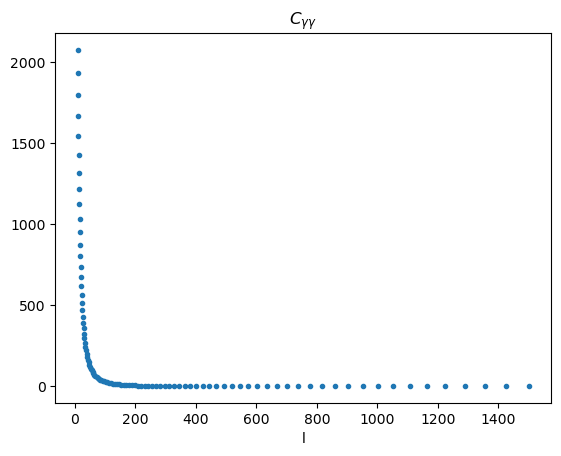

In [81]:
plt.plot(10**L_array, C, '.')
plt.title('$C_{\gamma \gamma}$')
plt.xlabel('l')
plt.show()

## Fisher Matrix

In [27]:
class Fisher:
    '''
    Calculate Fisher Matrix
    '''
    def __init__(self, params):
        self.num = params['num_params']
        self.universes = params['type']
        self.model = params['model']

    def trace(self, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, Cia):
        F = np.zeros((self.num + 2, self.num + 2))
        L_array = np.log10(np.logspace(np.log10(10), np.log10(1500), 100))
        cosmic_params = {'l': L_array , 'z': np.linspace(0.001, 2.5, 20), 'type': self.universes, 'model': self.model}
        A = CosmicShear(cosmic_params)
        
        f_sky = 0.3636
        epsilon = 0.01
        C = np.zeros((10, 10), dtype=object)
        dC_dq_Om_m_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_h_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_Om_b_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_Om_DE_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_w0_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_wa_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_ns_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_sig_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_gamma_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_Aia_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_bi_matrix = np.zeros((10, 10), dtype=object)
        dC_dq_bj_matrix = np.zeros((10, 10), dtype=object)
        
        for i in range(10):
            for j in range(i, 10):
                logging.info(f"Calculated pair: {(i, j)}")
                z_bins = [0.001, 0.42, 0.56, 0.68, 0.79, 0.9, 1.02, 1.15, 1.32, 1.58, 2.5]
                z_mean_i = z_bins[i] + ((z_bins[i+1] - z_bins[i]) / 2)
                bi = np.sqrt(1 + z_mean_i)
                z_mean_j = z_bins[j] + ((z_bins[j+1] - z_bins[j]) / 2)
                bj = np.sqrt(1 + z_mean_j)
                C[i, j] = C[j, i] = A.C_LL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj) + A.C_LL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj) + A.C_LL(i ,j, Omega_m0, h , Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, bi, bj) 
                dC_dq_Om_m_matrix[i, j] = dC_dq_Om_m_matrix[j, i] = A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'Omega_m0', 'LL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'Omega_m0', 'GL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'Omega_m0', 'GG')
                dC_dq_h_matrix[i, j] = dC_dq_h_matrix[j, i] = A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'h', 'LL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'h', 'GL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'h', 'GG')
                dC_dq_Om_b_matrix[i, j] = dC_dq_Om_b_matrix[j, i] = A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'Omega_b0', 'LL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'Omega_b0', 'GL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'Omega_b0', 'GG')
                dC_dq_Om_DE_matrix[i, j] = dC_dq_Om_DE_matrix[j, i] =  A.Der_C_parametro(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'Omega_DE0', 'LL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'Omega_DE0', 'GL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'Omega_DE0', 'GG')
                dC_dq_w0_matrix[i, j] = dC_dq_w0_matrix[j, i] = A.Der_C_parametro(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'w0', 'LL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'w0', 'GL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'w0', 'GG')
                dC_dq_wa_matrix[i, j] = dC_dq_wa_matrix[j, i] = A.Der_C_parametro(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'wa', 'LL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'wa', 'GL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'wa', 'GG')
                dC_dq_ns_matrix[i, j] =  dC_dq_ns_matrix[j, i]  = A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'ns', 'LL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'ns', 'GL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'ns', 'GG')
                dC_dq_sig_matrix[i, j] = dC_dq_sig_matrix[j, i] = A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'sigma8', 'LL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'sigma8', 'GL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'sigma8', 'GG')
                dC_dq_gamma_matrix[i, j] = dC_dq_gamma_matrix[j, i] = A.Der_C_parametro(i, j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'gamma', 'LL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'gamma', 'GL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'gamma', 'GG')
                dC_dq_Aia_matrix[i, j] =  dC_dq_Aia_matrix[j, i]  = A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'Aia', 'LL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'Aia', 'GL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'Aia', 'GG')
                dC_dq_bi_matrix[i, j] =  dC_dq_bi_matrix[j, i]  = A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'bi', 'LL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'bi', 'GL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'bi', 'GG')
                dC_dq_bj_matrix[i, j] =  dC_dq_bj_matrix[j, i]  = A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'bj', 'LL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'bj', 'GL') + A.Der_C_parametro(i ,j, epsilon, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, 'bj', 'GG')

                # Solo sumar C_LL y C_GG si j > i

        C_matrix = np.array(C.tolist(), dtype=float)
        C_matrix_2d = np.squeeze(C_matrix)

        dC_dq_Om_m_matrix = np.array(dC_dq_Om_m_matrix.tolist(), dtype=float)
        dC_dq_h_matrix = np.array(dC_dq_h_matrix.tolist(), dtype=float)
        dC_dq_Om_b_matrix = np.array(dC_dq_Om_b_matrix.tolist(), dtype=float)
        dC_dq_Om_DE_matrix = np.array(dC_dq_Om_DE_matrix.tolist(), dtype=float)
        dC_dq_w0_matrix = np.array(dC_dq_w0_matrix.tolist(), dtype=float)
        dC_dq_wa_matrix = np.array(dC_dq_wa_matrix.tolist(), dtype=float)
        dC_dq_ns_matrix = np.array(dC_dq_ns_matrix.tolist(), dtype=float)
        dC_dq_sig_matrix = np.array(dC_dq_sig_matrix.tolist(), dtype=float)
        dC_dq_gamma_matrix = np.array(dC_dq_gamma_matrix.tolist(), dtype=float)
        dC_dq_Aia_matrix = np.array(dC_dq_Aia_matrix.tolist(), dtype=float)
        dC_dq_bi_matrix = np.array(dC_dq_bi_matrix.tolist(), dtype=float)
        dC_dq_bj_matrix = np.array(dC_dq_bj_matrix.tolist(), dtype=float)

        dC_dq_Om_m_matrix_2d = np.squeeze(dC_dq_Om_m_matrix)
        dC_dq_h_matrix_2d = np.squeeze(dC_dq_h_matrix)
        dC_dq_Om_b_matrix_2d = np.squeeze(dC_dq_Om_b_matrix)
        dC_dq_Om_DE_matrix_2d = np.squeeze(dC_dq_Om_DE_matrix)
        dC_dq_w0_matrix_2d = np.squeeze(dC_dq_w0_matrix)
        dC_dq_wa_matrix_2d = np.squeeze(dC_dq_wa_matrix)
        dC_dq_ns_matrix_2d = np.squeeze(dC_dq_ns_matrix)
        dC_dq_sig_matrix_2d = np.squeeze(dC_dq_sig_matrix)
        dC_dq_gamma_matrix_2d = np.squeeze(dC_dq_gamma_matrix)
        dC_dq_Aia_matrix_2d = np.squeeze(dC_dq_Aia_matrix)
        dC_dq_bi_matrix_2d = np.squeeze(dC_dq_bi_matrix)
        dC_dq_bj_matrix_2d = np.squeeze(dC_dq_bj_matrix)
        
        for i, l in enumerate(L_array):

            if i < len(L_array) - 1:
                delta_l = 10**L_array[i+1] - 10**L_array[i]
            else: 
                 delta_l = 1
                 
            L_parameter = (((2*10**l + 1)*delta_l)/2)
            C_inv = np.linalg.inv(C_matrix_2d[:, :, i])

            #OMEGA_M 
            Om_m_Om_m = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv)
            Om_m_h = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_h_matrix_2d[:, :, i] @ C_inv)
            Om_m_Om_b = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            Om_m_Om_DE = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv)
            Om_m_w0 = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            Om_m_wa = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            Om_m_ns = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            Om_m_sig = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)
            Om_m_gamma = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)
            Om_m_Aia = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_Aia_matrix_2d[:, :, i] @ C_inv)
            Om_m_bi = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_bi_matrix_2d[:, :, i] @ C_inv)
            Om_m_bj = np.trace(dC_dq_Om_m_matrix_2d[:, :, i] @ C_inv @ dC_dq_bj_matrix_2d[:, :, i] @ C_inv)
#

            #H
            h_h = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_h_matrix_2d[:, :, i] @ C_inv)
            h_Om_b = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            h_Om_DE = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv)
            h_w0 = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            h_wa = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            h_ns = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            h_sig = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)
            h_gamma = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)
            h_Aia = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_Aia_matrix_2d[:, :, i] @ C_inv)
            h_bi = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_bi_matrix_2d[:, :, i] @ C_inv)
            h_bj = np.trace(dC_dq_h_matrix_2d[:, :, i] @ C_inv @ dC_dq_bj_matrix_2d[:, :, i] @ C_inv)
#
            #OMEGA_B
            Om_b_Om_b = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv)
            Om_b_Om_DE = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv)
            Om_b_w0 = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            Om_b_wa = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            Om_b_ns = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            Om_b_sig = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)
            Om_b_gamma = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)
            Om_b_Aia = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_Aia_matrix_2d[:, :, i] @ C_inv)
            Om_b_bi = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_bi_matrix_2d[:, :, i] @ C_inv)
            Om_b_bj = np.trace(dC_dq_Om_b_matrix_2d[:, :, i] @ C_inv @ dC_dq_bj_matrix_2d[:, :, i] @ C_inv)

            #OMEGA_DE
            Om_DE_Om_DE = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv)
            Om_DE_w0 = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            Om_DE_wa = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            Om_DE_ns = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            Om_DE_sig = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)
            Om_DE_gamma = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)
            Om_DE_Aia = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_Aia_matrix_2d[:, :, i] @ C_inv)
            Om_DE_bi = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_bi_matrix_2d[:, :, i] @ C_inv)
            Om_DE_bj = np.trace(dC_dq_Om_DE_matrix_2d[:, :, i] @ C_inv @ dC_dq_bj_matrix_2d[:, :, i] @ C_inv)

          #  #W0
            w0_w0 = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_w0_matrix_2d[:, :, i] @ C_inv)
            w0_wa = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            w0_ns = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            w0_sig = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)
            w0_gamma = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)
            w0_Aia = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_Aia_matrix_2d[:, :, i] @ C_inv)
            w0_bi = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_bi_matrix_2d[:, :, i] @ C_inv)
            w0_bj = np.trace(dC_dq_w0_matrix_2d[:, :, i] @ C_inv @ dC_dq_bj_matrix_2d[:, :, i] @ C_inv)
#
           # #WA
            wa_wa = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_wa_matrix_2d[:, :, i] @ C_inv)
            wa_ns = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            wa_sig = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv) 
            wa_gamma = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)    
            wa_Aia = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_Aia_matrix_2d[:, :, i] @ C_inv)   
            wa_bi = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_bi_matrix_2d[:, :, i] @ C_inv) 
            wa_bj = np.trace(dC_dq_wa_matrix_2d[:, :, i] @ C_inv @ dC_dq_bj_matrix_2d[:, :, i] @ C_inv)      

            #NS
            ns_ns = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_ns_matrix_2d[:, :, i] @ C_inv)
            ns_sig = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv)
            ns_gamma = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)
            ns_Aia = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_Aia_matrix_2d[:, :, i] @ C_inv)
            ns_bi = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_bi_matrix_2d[:, :, i] @ C_inv)
            ns_bj = np.trace(dC_dq_ns_matrix_2d[:, :, i] @ C_inv @ dC_dq_bj_matrix_2d[:, :, i] @ C_inv)

            #SIGMA8
            sig_sig = np.trace(dC_dq_sig_matrix_2d[:, :, i] @ C_inv @ dC_dq_sig_matrix_2d[:, :, i] @ C_inv) 
            sig_gamma = np.trace(dC_dq_sig_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)  
            sig_Aia = np.trace(dC_dq_sig_matrix_2d[:, :, i] @ C_inv @ dC_dq_Aia_matrix_2d[:, :, i] @ C_inv) 
            sig_bi = np.trace(dC_dq_sig_matrix_2d[:, :, i] @ C_inv @ dC_dq_bi_matrix_2d[:, :, i] @ C_inv)  
            sig_bj = np.trace(dC_dq_sig_matrix_2d[:, :, i] @ C_inv @ dC_dq_bj_matrix_2d[:, :, i] @ C_inv)  

            #GAMMA
            gamma_gamma = np.trace(dC_dq_gamma_matrix_2d[:, :, i] @ C_inv @ dC_dq_gamma_matrix_2d[:, :, i] @ C_inv)  
            gamma_Aia = np.trace(dC_dq_gamma_matrix_2d[:, :, i] @ C_inv @ dC_dq_Aia_matrix_2d[:, :, i] @ C_inv)  
            gamma_bi = np.trace(dC_dq_gamma_matrix_2d[:, :, i] @ C_inv @ dC_dq_bi_matrix_2d[:, :, i] @ C_inv)  
            gamma_bj = np.trace(dC_dq_gamma_matrix_2d[:, :, i] @ C_inv @ dC_dq_bj_matrix_2d[:, :, i] @ C_inv)  

            #Aia
            Aia_Aia = np.trace(dC_dq_Aia_matrix_2d[:, :, i] @ C_inv @ dC_dq_Aia_matrix_2d[:, :, i] @ C_inv)
            Aia_bi = np.trace(dC_dq_Aia_matrix_2d[:, :, i] @ C_inv @ dC_dq_bi_matrix_2d[:, :, i] @ C_inv) 
            Aia_bj = np.trace(dC_dq_Aia_matrix_2d[:, :, i] @ C_inv @ dC_dq_bj_matrix_2d[:, :, i] @ C_inv)  

            #bi
            bi_bi = np.trace(dC_dq_bi_matrix_2d[:, :, i] @ C_inv @ dC_dq_bi_matrix_2d[:, :, i] @ C_inv)
            bi_bj = np.trace(dC_dq_bi_matrix_2d[:, :, i] @ C_inv @ dC_dq_bj_matrix_2d[:, :, i] @ C_inv)

            #bj
            bj_bj = np.trace(dC_dq_bj_matrix_2d[:, :, i] @ C_inv @ dC_dq_bj_matrix_2d[:, :, i] @ C_inv)




            if self.model == 'ACDM_flat':
                coeficientes = {
                        (0, 0): Om_m_Om_m, (0, 1): Om_m_h, (0, 2): Om_m_Om_b, (0, 3): Om_m_ns, (0, 4): Om_m_sig, (0, 5): Om_m_Aia, (0, 6): Om_m_bi, (0, 7): Om_m_bj,
                        (1, 1): h_h, (1, 2): h_Om_b, (1, 3): h_ns, (1, 4): h_sig, (1, 5): h_Aia, (1, 6): h_bi, (1, 7): h_bj,
                        (2, 2): Om_b_Om_b, (2, 3): Om_b_ns, (2, 4): Om_b_sig, (2, 5): Om_b_Aia, (2, 6): Om_b_bi, (2, 7): Om_b_bj,
                        (3, 3): ns_ns, (3, 4): ns_sig, (3, 5): ns_Aia, (3, 6): ns_bi, (3, 7): ns_bj,
                        (4, 4): sig_sig, (4, 5): sig_Aia, (4, 6): sig_bi, (4, 7): sig_bj,
                        (5, 5): Aia_Aia, (5, 6): Aia_bi, (5, 7): Aia_bj,
                        (6, 6): bi_bi, (6, 7): bi_bj,
                        (7, 7): bj_bj                   }

                for (i, j), coef in coeficientes.items():
                    F[i, j] += L_parameter * coef
            
            if self.model == 'ACDM_non_flat':
                coeficientes = {
                    (0, 0): Om_m_Om_m, (0, 1): Om_m_h, (0, 2): Om_m_Om_b, (0, 3):Om_m_Om_DE, (0, 4): Om_m_ns, (0, 5): Om_m_sig, (0, 6): Om_m_Aia, (0, 7): Om_m_b, 
                    (1, 1): h_h, (1, 2): h_Om_b, (1, 3): h_Om_DE, (1, 4): h_ns, (1, 5): h_sig, (1, 6): h_Aia, (1, 7): h_b,
                    (2, 2): Om_b_Om_b, (2, 3): Om_b_Om_DE, (2, 4): Om_b_ns, (2, 5): Om_b_sig, (2, 6): Om_b_Aia, (2, 7): Om_b_b,
                    (3, 3): Om_DE_Om_DE, (3, 4): Om_DE_ns, (3, 5): Om_DE_sig, (3, 6): Om_DE_Aia, (3, 6): Om_DE_Aia, (3, 7): Om_DE_b,
                    (4, 4): ns_ns, (4, 5): ns_sig, (4, 6): ns_Aia, (4, 7): ns_b,
                    (5, 5): sig_sig, (5, 6): sig_Aia, (5, 7): sig_b,
                    (6, 6): Aia_Aia, (6, 7): Aia_b, 
                    (7, 7): b_b
                }

                for (i, j), coef in coeficientes.items():
                    F[i, j] += L_parameter * coef

            if self.model == 'non_ACDM_flat':
                coeficientes = {
                    (0, 0): Om_m_Om_m, (0, 1): Om_m_h, (0, 2): Om_m_Om_b, (0, 3): Om_m_w0, (0, 4): Om_m_wa, (0, 5): Om_m_ns, (0, 6): Om_m_sig, (0, 7): Om_m_Aia, (0, 8): Om_m_b,
                    (1, 1): h_h, (1, 2): h_Om_b, (1, 3): h_w0, (1, 4): h_wa, (1, 5): h_ns, (1, 6): h_sig, (1, 7): h_Aia, (1, 8): h_b,
                    (2, 2): Om_b_Om_b, (2, 3): Om_b_w0, (2, 4): Om_b_wa, (2, 5): Om_b_ns, (2, 6): Om_b_sig, (2, 7): Om_b_Aia, (2, 8): Om_b_b,
                    (3, 3): w0_w0, (3, 4): w0_wa, (3, 5): w0_ns, (3, 6): w0_sig, (3, 7): w0_Aia, (3, 8): w0_b,
                    (4, 4): wa_wa, (4, 5): wa_ns, (4, 6): wa_sig, (4, 7): wa_Aia, (4, 8): wa_b,
                    (5, 5): ns_ns, (5, 6): ns_sig, (5, 7): ns_Aia, (5, 8): ns_b,
                    (6, 6): sig_sig, (6, 7): sig_Aia, (6, 8): sig_b,
                    (7, 7): Aia_Aia, (7, 8): Aia_Aia,
                    (8, 8): b_b
                }

                for (i, j), coef in coeficientes.items():
                    F[i, j] += L_parameter * coef

            if self.model == 'non_ACDM_non_flat':
                coeficientes = {
                    (0, 0): Om_m_Om_m, (0, 1): Om_m_h, (0, 2): Om_m_Om_b, (0, 3): Om_m_Om_DE, (0, 4): Om_m_w0, (0, 5): Om_m_wa, (0, 6): Om_m_ns, (0, 7): Om_m_sig, (0, 8): Om_m_Aia, (0, 9): Om_m_b,
                    (1, 1): h_h, (1, 2): h_Om_b, (1, 3): h_Om_DE, (1, 4): h_w0, (1, 5): h_wa, (1, 6): h_ns, (1, 7): h_sig, (1, 8): h_Aia, (1, 9): h_b,
                    (2, 2): Om_b_Om_b, (2, 3): Om_b_Om_DE, (2, 4): Om_b_w0, (2, 5): Om_b_wa, (2, 6): Om_b_ns, (2, 7): Om_b_sig, (2, 8): Om_b_Aia, (2, 9): Om_b_b,
                    (3, 3): Om_DE_Om_DE, (3, 4): Om_DE_w0, (3, 5): Om_DE_wa, (3, 6): Om_DE_ns, (3, 7): Om_DE_sig, (3, 8): Om_DE_Aia, (3, 9): Om_DE_b,
                    (4, 4): w0_w0, (4, 5): w0_wa, (4, 6): w0_ns, (4, 7): w0_sig, (4, 8): w0_Aia, (4, 9): w0_b, 
                    (5, 5): wa_wa, (5, 6): wa_ns, (5, 7): wa_sig, (5, 8): wa_Aia, (5, 9): wa_b,
                    (6, 6): ns_ns, (6, 7): ns_sig, (6, 8): ns_Aia, (6, 9): ns_b,
                    (7, 7): sig_sig, (7, 8): sig_Aia, (7, 9): sig_b,
                    (8, 8): Aia_Aia, (8, 9): Aia_b,
                    (8, 8): b_b
                }
                for (i, j), coef in coeficientes.items():
                    F[i, j] += L_parameter * coef

            if self.model == 'non_ACDM_flat_gamma':
                coeficientes = {
                    (0, 0): Om_m_Om_m, (0, 1): Om_m_h, (0, 2): Om_m_Om_b, (0, 3): Om_m_w0, (0, 4): Om_m_wa, (0, 5): Om_m_ns, (0, 6): Om_m_sig, (0, 7): Om_m_gamma, (0, 8): Om_m_Aia, (0, 9): Om_m_b,
                    (1, 1): h_h, (1, 2): h_Om_b, (1, 3): h_w0, (1, 4): h_wa, (1, 5): h_ns, (1, 6): h_sig, (1, 7): h_gamma, (1, 8): h_Aia, (1, 9): h_b, 
                    (2, 2): Om_b_Om_b, (2, 3): Om_b_w0, (2, 4): Om_b_wa, (2, 5): Om_b_ns, (2, 6): Om_b_sig, (2, 7): Om_b_gamma, (2, 8): Om_b_Aia, (2, 9): Om_b_b,
                    (3, 3): w0_w0, (3, 4): w0_wa, (3, 5): w0_ns, (3, 6): w0_sig, (3, 7): w0_gamma, (3, 8): w0_Aia, (3, 9): w0_b, 
                    (4, 4): wa_wa, (4, 5): wa_ns, (4, 6): wa_sig, (4, 7): wa_gamma, (4, 8): wa_Aia, (4, 9): wa_b, 
                    (5, 5): ns_ns, (5, 6): ns_sig, (5, 7): ns_gamma, (5, 8): ns_Aia, (5, 9): ns_b, 
                    (6, 6): sig_sig, (6, 7): sig_gamma, (6, 8): sig_Aia, (6, 9): sig_b,
                    (7, 7): gamma_gamma, (7, 8): gamma_Aia, (7, 9): gamma_b,
                    (8, 8): Aia_Aia, (8, 9): gamma_b,
                    (9, 9): b_b
                }
                for (i, j), coef in coeficientes.items():
                    F[i, j] += L_parameter * coef

            if self.model == 'non_ACDM_non_flat_gamma':
                coeficientes = {
                    (0, 0): Om_m_Om_m, (0, 1): Om_m_h, (0, 2): Om_m_Om_b, (0, 3): Om_m_Om_DE, (0, 4): Om_m_w0, (0, 5): Om_m_wa, (0, 6): Om_m_ns, (0, 7): Om_m_sig, (0, 8): Om_m_gamma, (0, 9): Om_m_Aia, (0, 10): Om_m_b,
                    (1, 1): h_h, (1, 2): h_Om_b, (1, 3): h_Om_DE, (1, 4): h_w0, (1, 5): h_wa, (1, 6): h_ns, (1, 7): h_sig, (1, 8): h_gamma, (1, 9): h_Aia, (1, 10): h_b, 
                    (2, 2): Om_b_Om_b, (2, 3): Om_b_Om_DE, (2, 4): Om_b_w0, (2, 5): Om_b_wa, (2, 6): Om_b_ns, (2, 7): Om_b_sig, (2, 8): Om_b_gamma, (2, 9): Om_b_Aia, (2, 10): Om_b_b,
                    (3, 3): Om_DE_Om_DE, (3, 4): Om_DE_w0, (3, 5): Om_DE_wa, (3, 6): Om_DE_ns, (3, 7): Om_DE_sig, (3, 8): Om_DE_gamma, (3, 9): Om_DE_Aia, (3, 10): Om_DE_b,
                    (4, 4): w0_w0, (4, 5): w0_wa, (4, 6): w0_ns, (4, 7): w0_sig, (4, 8): w0_gamma, (4, 9): w0_Aia, (4, 10): w0_b, 
                    (5, 5): wa_wa, (5, 6): wa_ns, (5, 7): wa_sig, (5, 8): wa_gamma, (5, 9): wa_Aia, (5, 10): wa_b, 
                    (6, 6): ns_ns, (6, 7): ns_sig, (6, 8): ns_gamma, (6, 9): ns_Aia, (6, 9): ns_b, 
                    (7, 7): sig_sig, (7, 8): sig_gamma, (7, 9): sig_Aia, (7, 10): sig_b,
                    (8, 8): gamma_gamma, (8, 9): gamma_Aia, (8, 10): gamma_b,
                    (9, 9): Aia_Aia, (9, 10): Aia_Aia,
                    (10, 10): b_b
                }
                for (i, j), coef in coeficientes.items():
                    F[i, j] += L_parameter * coef

        Fisher = F + F.T - np.diag(F.diagonal())
        logging.info(f"Fisher Matrix: {Fisher}")

        return f_sky*Fisher

In [28]:
params = {'num_params': 5, 'type': 'standard', 'model' : 'ACDM_flat'}

A = Fisher(params)

F = A.trace(Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, Cia)

Cov = np.linalg.inv(F)

print('Matriz de covarianzas')

print(' ')

print(Cov)

INFO:root:Calculated pair: (0, 0)


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [88]:
stop

NameError: name 'stop' is not defined

____________________

# Borradores

In [ ]:

    def K(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, Cia):

        H_0 = (100 * h)
        c = 299792
        z_prime= self.z

        params = {'z': z_prime, 'model': self.model}
    
        A = ClassIntegration(params)

        H_array = H_0 * self.E2(z_prime, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma)
        Wi_L = np.array(A.Window_gamma(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        Wj_L = np.array(A.Window_gamma(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma))
        Wi_G = np.array(A.Window_G(i, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, Cia))
        Wj_G = np.array(A.Window_G(j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, Cia))
        r_array = np.array([self.r(zs, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for zs in z_prime])

        K_LL = ((Wi_L * Wj_L) / (H_array * (r_array ** 2) ))
        K_GL = ((Wi_G * Wj_L) / (H_array * (r_array ** 2) ))
        K_GG = ((Wi_G * Wj_G) / (H_array * (r_array ** 2) ))

        return K_LL, K_GL, K_GG

    def Cosmic_Shear_l3(self, i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, Cia):
        z_max, z_min, z0 = 2.5, 0.001, 0.62
        z_prime, delta = self.z, (z_max - z_min) / len(self.z)
        SN_LL, SN_GL, SN_GG = self.SN(i, j)
        
        result = []

        K_gg, K_Ig, K_II = self.K(i ,j, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma, Aia, Cia)

        for ls in self.l:

            P_gg = np.array([self.PPS(z_primes, ls, Omega_m0, h, Omega_b0, Omega_DE0, w0, wa, ns, sigma8, gamma) for z_primes in z_prime])

            integrand = ((K_gg * P_gg) + (K_Ig * P_gg) + (K_II * P_gg)) * float(delta)
            integral =  np.sum(integrand)
            integral_final = c * integral + SN_LL + SN_GL + SN_GG

            result.append(integral_final)

        return np.array(result)